In [2]:
from tensorflow.keras.layers import  Dense, Dropout,  Input, Reshape, Conv1D, Activation,BatchNormalization, MaxPooling1D,LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
import scipy.io
from scipy import signal
import glob
import numpy as np
import os
import pandas as pd

In [3]:
#Declaring the variables
BATCH_SIZE=25
EPOCHS=100
BASE_DIR='C:/Users/EE/Documents/Python Scripts/CorNet'

In [4]:
def Core_net():    
    i=Input(shape=(1000,1),name="input")
    m=Conv1D(32,kernel_size=40)(i)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    m=Conv1D(32,kernel_size=40)(m)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    m=LSTM(128, activation='tanh',return_sequences=True)(m)
    m=LSTM(128, activation='tanh')(m)
    m=Dense(1)(m)
    newmodel = Model(inputs=i,outputs=m)
    return newmodel

In [5]:
corenet=Core_net()
corenet.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 961, 32)           1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 961, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 961, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 240, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 240, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 201, 32)          

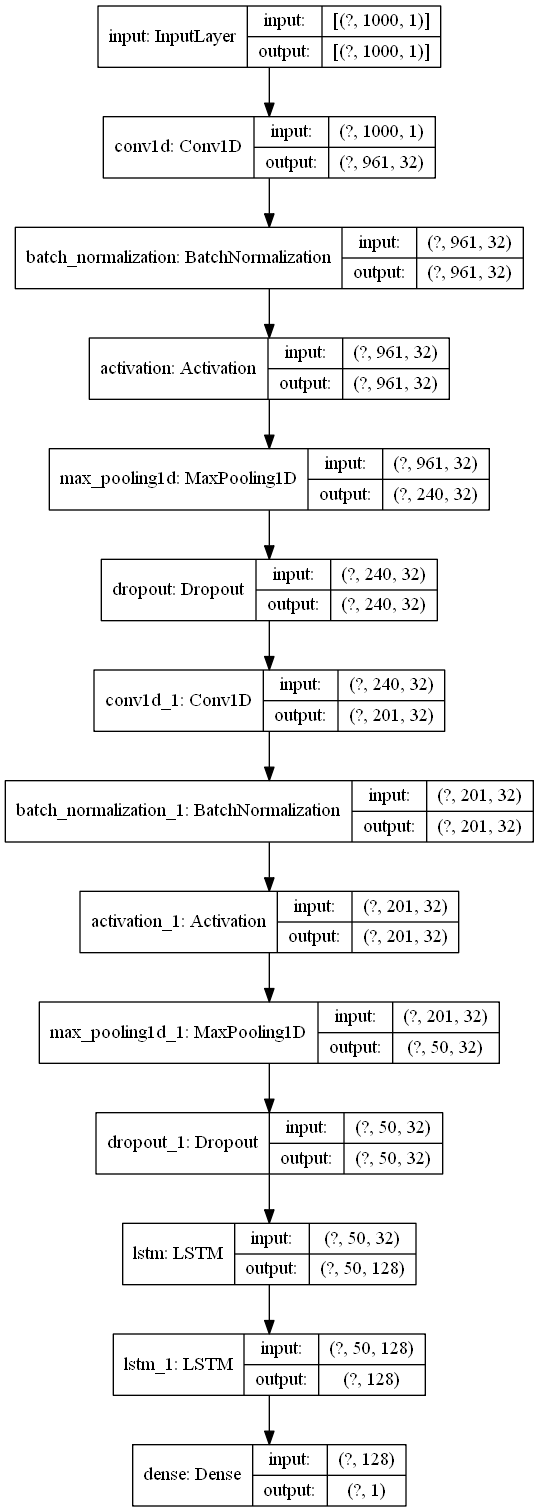

In [6]:
plot_model(corenet,show_shapes=True)

In [7]:
# Reading Datafiles
files = [f for f in glob.glob("**/*.mat", recursive=True)]

True_files=np.append(files[0:13], files[59:69])
Data_files=files[36:59]


In [49]:
# Callback for saving model weights and log training results
def get_callbacks(name_weights):
    mcp_save = ModelCheckpoint(name_weights+"_weights.hdf5", save_best_only=True, monitor='val_loss', mode='min')
    csv_log=CSVLogger(name_weights+'.csv',separator=',')
    return [mcp_save, csv_log]

In [ ]:
# Training loop with leave one window out strategy. For each window left out we train the model for 100 epochs. 
for d in range(len(Data_files)):
    mat = scipy.io.loadmat(Data_files[d])
    mattrue=scipy.io.loadmat(True_files[d])
    truebpm=mattrue['BPM0']
    PPG1=np.array(mat['PPG1_filt'])
    PPG2=np.array(mat['PPG2_filt'])
    PPG=PPG1#np.concatenate((PPG1,PPG2))
    PPG_True_1=truebpm#np.concatenate((truebpm,truebpm))
    print('Training for Subject: ',d)
    corenet=Core_net()
    corenet.compile(optimizer='RMSprop', loss='mean_absolute_error', metrics=['mse','mape'])
    weight_dir=BASE_DIR+'/Subject_'+str(EPOCHS)+'_'+str(d)+'/'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    
    if d==130:
        pass
    else:
        # Impllementing leave one out validation
        for j in range(len(PPG)):
            print('\nFold: ',j)
            Loo_Train=PPG[j]
            Loo_True=PPG_True_1[j]
            # If selected window for testing is less than total windows then select window without overlap
            if j+4<len(PPG):      
                if j<4:
                    PPG_Train=PPG[j+4:]
                    PPG_True=PPG_True_1[j+4:]
                elif j>=4:
                    PPG_Train=np.concatenate((PPG[j+4:],PPG[0:j-4+1]))
                    PPG_True=np.concatenate((PPG_True_1[j+4:],PPG_True_1[0:j-4+1]))
            elif j+4>=len(PPG):
                PPG_Train=PPG[0:j-4+1]
                PPG_True=PPG_True_1[0:j-4+1]
            PPG_Train_data=np.reshape(PPG_Train,(PPG_Train.shape[0],1000,1))
            Loo_Train_data=np.reshape(Loo_Train,(1,1000,1))
            # Training and Saving the weights
            name_weights = weight_dir+"Subject_"+str(d)+"_fold_" + str(j)
            callbacks = get_callbacks(name_weights) 
            history=corenet.fit(PPG_Train_data,PPG_True, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,validation_data=(Loo_Train_data,Loo_True),callbacks=callbacks,use_multiprocessing=True)
            results=corenet.evaluate(np.reshape(PPG,(PPG.shape[0],1000,1)),PPG_True_1, batch_size=BATCH_SIZE)
            print('\nModel Evaluation: ',results)
        
        print(d)

In [15]:
# Getting inference for all the windows for a subject and computing mean absolute error.
StatList=[]
BPM_dir=BASE_DIR
EPOCHS=100
for d in range(len(Data_files)):
        mat = scipy.io.loadmat(Data_files[d])
        mattrue=scipy.io.loadmat(True_files[d])
    
        truebpm=mattrue['BPM0']
        PPG1=np.array(mat['PPG1_filt'])
        PPG2=np.array(mat['PPG2_filt'])
        print(PPG1.shape)
        PPG=PPG1#np.concatenate((PPG1,PPG2))
        PPG_True_1=truebpm#np.concatenate((truebpm,truebpm))
        corenet=Core_net()
        corenet.load_weights(BPM_dir+'/Subject_'+str(EPOCHS)+'_'+str(d)+'/Subject_'+str(d)+'_fold_'+str(len(truebpm)-1)+'_weights.hdf5')
        #corenet.load_weights(BPM_dir+'/Subject'+str(d)+'/Subject_'+str(d)+'_fold_'+str(len(truebpm)-1)+'_weights.h5')
        #time_start = time.time()
        preds=corenet.predict(np.reshape(PPG,(PPG.shape[0],1000,1)))
        #print((time.time() - time_start))
        filename = BPM_dir+'/Est_'+True_files[d]
        scipy.io.savemat(filename,{"Estimate":preds})
        StatList.append(['Subject '+str(d),np.mean(np.absolute(truebpm-preds)),np.std(np.absolute(truebpm-preds))])

(148, 1000)
(148, 1000)
(140, 1000)
(146, 1000)
(146, 1000)
(150, 1000)
(143, 1000)
(160, 1000)
(149, 1000)
(149, 1000)
(143, 1000)
(146, 1000)
(107, 1000)
(142, 1000)
(137, 1000)
(144, 1000)
(152, 1000)
(101, 1000)
(157, 1000)
(132, 1000)
(142, 1000)
(121, 1000)
(100, 1000)


In [16]:
print("Results of Training CoreNet each fold for 100 epochs")
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
print (df)

Results of Training CoreNet each fold for 100 epochs
       Subject      Mean     StDev
0    Subject 0  0.062771  0.231311
1    Subject 1  0.104994  0.034440
2    Subject 2  0.038111  0.052441
3    Subject 3  0.063979  0.054876
4    Subject 4  0.077718  0.146396
5    Subject 5  0.031997  0.025083
6    Subject 6  0.029438  0.021675
7    Subject 7  0.036528  0.178523
8    Subject 8  0.036574  0.027318
9    Subject 9  0.051035  0.118704
10  Subject 10  0.036061  0.022981
11  Subject 11  0.060643  0.040399
12  Subject 12  6.726908  5.522086
13  Subject 13  0.062309  0.031917
14  Subject 14  0.079044  0.052987
15  Subject 15  0.032812  0.021696
16  Subject 16  0.025586  0.019934
17  Subject 17  0.030908  0.064600
18  Subject 18  0.024347  0.019289
19  Subject 19  0.108101  0.144826
20  Subject 20  8.715208  8.117884
21  Subject 21  7.127148  5.072060
22  Subject 22  3.066573  2.284916


In [12]:
print("Results of Training CoreNet each fold for 1 epochs")
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
print (df)

Results of Training CoreNet each fold for 1 epochs
       Subject       Mean      StDev
0    Subject 0  25.325802  12.493779
1    Subject 1  17.449993  12.707564
2    Subject 2  21.706259  10.690097
3    Subject 3  22.227934  11.646172
4    Subject 4  21.117947  10.821248
5    Subject 5  19.281033  15.100565
6    Subject 6  21.242753   9.193110
7    Subject 7  14.692729  12.941040
8    Subject 8  19.523367  11.474620
9    Subject 9  30.499764  12.460659
10  Subject 10  29.790947  13.497701
11  Subject 11  24.422614  11.782405
12  Subject 12  19.778134   8.312007
13  Subject 13   7.777050   6.464122
14  Subject 14   8.814961   7.035914
15  Subject 15  14.385831  10.946384
16  Subject 16  27.917966   9.042626
17  Subject 17  55.104975  12.572268
18  Subject 18   6.304108   3.748578
19  Subject 19  12.198338   7.173826
20  Subject 20  18.820592  10.275418
21  Subject 21  35.071848   8.529417
22  Subject 22  20.609093   3.705592


In [14]:
print("Results of Training CoreNet each fold for 10 epochs")
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
print (df)

Results of Training CoreNet each fold for 10 epochs
       Subject       Mean      StDev
0    Subject 0   0.311299   0.879816
1    Subject 1   0.117167   0.225423
2    Subject 2   6.469894  14.218465
3    Subject 3   0.274175   0.264422
4    Subject 4   0.099227   0.057106
5    Subject 5   0.079936   0.191996
6    Subject 6  15.608312  15.681761
7    Subject 7   0.316162   0.280834
8    Subject 8   0.927414   2.461301
9    Subject 9   0.183353   0.215299
10  Subject 10   0.234263   0.202001
11  Subject 11   0.128746   0.197216
12  Subject 12   6.721651   5.536520
13  Subject 13   0.063078   0.046166
14  Subject 14   0.067430   0.060499
15  Subject 15   0.113695   0.127465
16  Subject 16   0.080870   0.062594
17  Subject 17  10.612551   6.762981
18  Subject 18   0.113111   0.056436
19  Subject 19   0.190097   0.640249
20  Subject 20   0.104982   0.081448
21  Subject 21   7.127176   5.070742
22  Subject 22   0.103656   0.069457
